# Bayesian data analysis - PyStan demos
Author: Aki Vehtari, Markus Paasiniemi

License: CC-BY

Examples how to use [Stan](http://mc-stan.org) in Python with [PyStan](http://pystan.readthedocs.org). This notebook assumes basic knowledge of Bayesian inference and MCMC. The Stan models are stored in separate .stan-files.

## Setting up the PyStan environment

We begin by importing the PyStan module as well at the matplotlib module for basic graphics facilities.

In [1]:
%matplotlib inline

import numpy as np
import pystan
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# edit default plot settings
plt.rc('font', size=12)

We also import some utilities by Michael Betancourt and introduced in [PyStan workflow case study](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html)

In [3]:
import stan_utility

## Bernoulli model

Toy data with sequence of failures (0) and successes (1). We would like to learn about the unknown probability of success.

In [4]:
data = dict(N=10, y=[0,1,0,0,1,1,1,0,1,0])

Bernoulli model with a Beta(1,1) (uniform) prior

In [5]:
%cat bern.stan

// Bernoulli model
data {
  int<lower=0> N;
  int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ bernoulli(theta);
}


Given the Stan program we then use the `compile_model` method of `stan_utility` module to compile the Stan program into a C++ executable. This utility function automatically saves a cached version of the compiled model to the disk for possible future use.

In [7]:
model = stan_utility.compile_model('bern.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4586f2dc76604848221fafe6413762a9 NOW.


Recompiling the model again with the utility function uses the cached version automatically.

In [8]:
del model
model = stan_utility.compile_model('bern.stan')

Using cached StanModel


Sample form the posterior, show the summary and plot the histogram of the posterior draws.

Inference for Stan model: anon_model_4586f2dc76604848221fafe6413762a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.49  3.5e-3   0.14   0.23    0.4    0.5   0.59   0.76   1515    1.0
lp__   -8.82    0.02   0.75  -10.9  -8.96  -8.54  -8.37  -8.32   1644    1.0

Samples were drawn using NUTS at Wed Aug 23 10:31:47 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


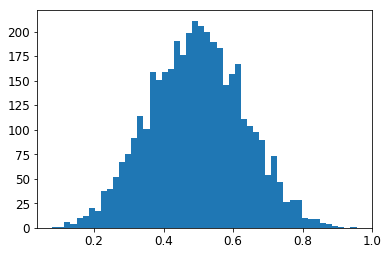

In [9]:
fit = model.sampling(data=data)
print(fit)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 50);

## Binomial model

Instead of sequence of 0's and 1's, we can summarize the data with the number of experiments and the number successes:

In [10]:
data = dict(N=10, y=8)

And then we use Binomial model with Beta(1,1) prior for the probability of success.

In [11]:
%cat binom.stan

// Binomial model with beta(1,1,) prior
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ binomial(N,theta);
}


Sample from the posterior and plot the posterior. The histogram should look similar as in the Bernoulli case.

Using cached StanModel


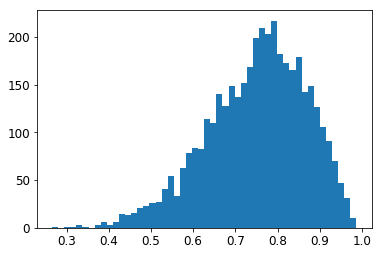

In [12]:
model = stan_utility.compile_model('binom.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 50);

Re-run the model with a new data. Here the same compiled model object is reused.

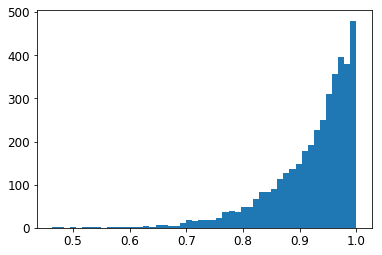

In [13]:
data = dict(N=10, y=10)
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 50);

## Comparison of two groups with Binomial

An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients. A group of patients were randomly assigned to treatment and control groups:

- out of 674 patients receiving the control, 39 died
- out of 680 receiving the treatment, 22 died

In [14]:
data = dict(N1=674, y1=39, N2=680, y2=22)

To analyse whether the treatment is useful, we can use Binomial model for both groups and compute odds-ratio:

In [15]:
%cat binom2.stan

//  Comparison of two groups with Binomial
data {
  int<lower=0> N1;
  int<lower=0> y1;
  int<lower=0> N2;
  int<lower=0> y2;
}
parameters {
  real<lower=0,upper=1> theta1;
  real<lower=0,upper=1> theta2;
}
model {
  theta1 ~ beta(1,1);
  theta2 ~ beta(1,1);
  y1 ~ binomial(N1,theta1);
  y2 ~ binomial(N2,theta2);
}
generated quantities {
  real oddsratio;
  oddsratio = (theta2/(1-theta2))/(theta1/(1-theta1));
}


Sample from the posterior and plot the posterior

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7225537f3d9d3af861d4f45c7f8da01 NOW.


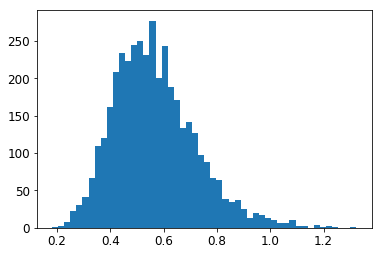

In [16]:
model = stan_utility.compile_model('binom2.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)
plt.hist(samples['oddsratio'], 50);

## Linear Gaussian model

The following file has Kilpisjärvi summer month temperatures 1952-2013:

In [17]:
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
x = d[:, 0]
y = d[:, 4]
N = len(x)
xpred = 2016

Plot the data

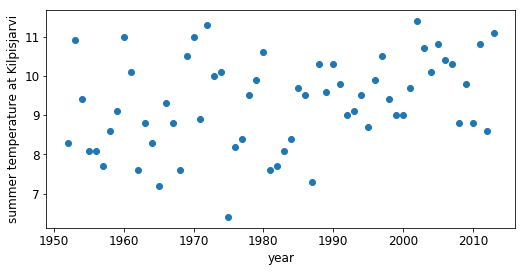

In [18]:
# make slightly wider figure
wide_figsize = plt.rcParams['figure.figsize'].copy()
wide_figsize[0] *= 1.4
plt.figure(figsize=wide_figsize)
plt.scatter(x, y)
plt.xlabel('year')
plt.ylabel('summer temperature at Kilpisjarvi');

To analyse whether the average summer month temperature is rising, we use a linear model with Gaussian model for the unexplained variation. 

### Gaussian linear model with adjustable priors

The folloing Stan code allows also setting hyperparameter values as data allowing easier way to use different priors in different analyses:

In [19]:
%cat lin.stan

// Gaussian linear model with adjustable priors
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
  real pmualpha; // prior mean for alpha
  real psalpha;  // prior std for alpha
  real pmubeta;  // prior mean for beta
  real psbeta;   // prior std for beta
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  alpha ~ normal(pmualpha, psalpha);
  beta ~ normal(pmubeta, psbeta);
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}


Create a list with data and priors:

In [20]:
data = dict(
    N = N,
    x = x,
    y = y,
    xpred = xpred,
    pmualpha = y.mean(),     # centered
    psalpha  = 100,          # weakly informative prior
    pmubeta  = 0,            # a priori increase and decrese as likely
    psbeta   = (.1--.1)/6.0  # avg temp probably does not increase more than 1
                             # degree per 10 years
)

Run Stan

In [21]:
model = stan_utility.compile_model('lin.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [22]:
print(fit)

Inference for Stan model: anon_model_6d95d5cbf9b9fb7d99a793b066a7bb72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -28.87    0.49  15.12 -58.63 -38.93 -29.61 -18.98   1.76    965    1.0
beta          0.02  2.5e-4 7.6e-3 3.8e-3   0.01   0.02   0.02   0.03    966    1.0
sigma         1.13  3.3e-3   0.11   0.95   1.06   1.12    1.2   1.37   1083    1.0
mu[0]         8.73  8.1e-3   0.28    8.2   8.55   8.72   8.91   9.31   1167    1.0
mu[1]         8.75  7.8e-3   0.27   8.23   8.57   8.74   8.92   9.32   1181    1.0
mu[2]         8.77  7.6e-3   0.26   8.26   8.59   8.76   8.94   9.32   1197    1.0
mu[3]         8.79  7.4e-3   0.26   8.29   8.62   8.78   8.95   9.33   1214    1.0
mu[4]          8.8  7.1e-3   0.25   8.32   8.64    8.8   8.97   9.33   1232    1.0
mu[5]         8.82  6.9e-3   0.24   8.35   8.66   8.82   8.98   

Check the treedepth, E-BFMI, and divergences

In [23]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

92 of 4000 iterations saturated the maximum tree depth of 10 (2.3%)
Run again with max_depth set to a larger value to avoid saturation
0.0 of 4000 iterations ended with a divergence (0.0%)


We get a warning that several iterations that saturated the maximum treedepth". The reason for this is a very strong posterior correlation between alpha and beta as shown in the next plot. This doesn't imvalidate the results, but leads to suboptimal performance. We'll later look at alternative which reduces the posterior correlation. The following figure shows the strong posterior correlation in the current case.

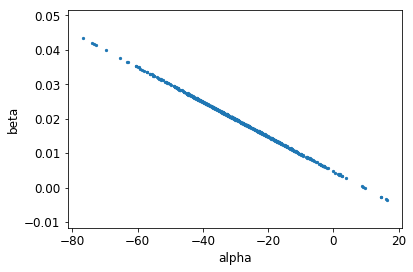

In [24]:
samples = fit.extract(permuted=True)
# preview 500 posterior samples of (alpha, beta)
plt.scatter(samples['alpha'][:500], samples['beta'][:500], 5)
plt.xlabel('alpha')
plt.ylabel('beta');

Compute the probability that the summer temperature is increasing.

In [25]:
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

Pr(beta > 0) = 0.99125


Plot the data, the model fit and prediction for year 2016.

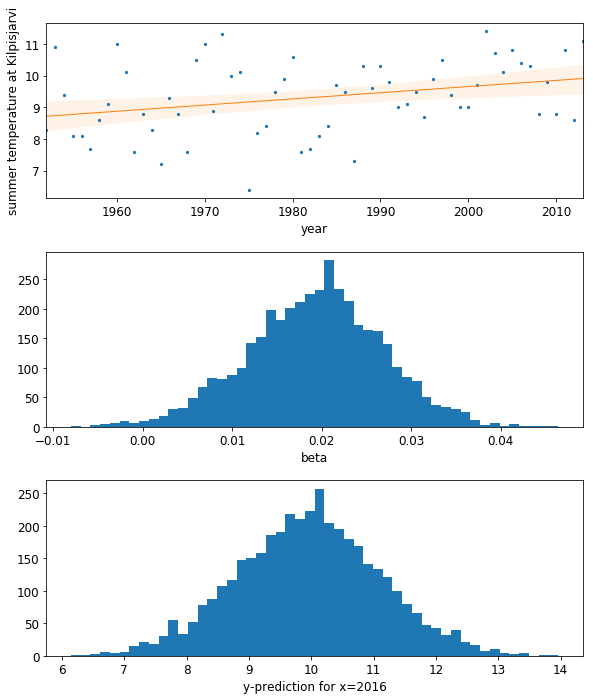

In [26]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 1.4  # width
figsize[1] *= 2.5  # height
fig, axes = plt.subplots(3, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
# lighten color_line
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
# plot
ax = axes[0]
ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('summer temperature at Kilpisjarvi')
ax.set_xlim((1952, 2013))

# plot 2: histogram
ax = axes[1]
ax.hist(samples['beta'], 50)
ax.set_xlabel('beta')

# plot 3: histogram
ax = axes[2]
ax.hist(samples['ypred'], 50)
ax.set_xlabel('y-prediction for x={}'.format(xpred))

# make figure compact
fig.tight_layout();

### Gaussian linear model with standardized data

In the above we used the unnormalized data and as x values are far away from zero, this will cause very strong posterior dependency between alpha and beta (did you use ShinyStan for the above model?). The strong posterior dependency can be removed by normalizing the data to have zero mean. The following Stan code makes it in Stan. In generated quantities we do correspnding transformation back to the original scale.

In [27]:
%cat lin_std.stan

// Gaussian linear model with standardized data
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
}
transformed data {
  vector[N] x_std;
  vector[N] y_std;
  x_std = (x - mean(x)) / sd(x);
  y_std = (y - mean(y)) / sd(y);
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma_std;
}
transformed parameters {
  vector[N] mu_std;
  mu_std = alpha + beta*x_std;
}
model {
  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  y_std ~ normal(mu_std, sigma_std);
}
generated quantities {
  vector[N] mu;
  real<lower=0> sigma;
  real ypred;
  vector[N] log_lik;
  mu = mu_std*sd(y) + mean(y);
  sigma = sigma_std*sd(y);
  ypred = normal_rng((alpha + beta*xpred)*sd(y)+mean(y), sigma*sd(y));
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}


Run Stan

In [28]:
model = stan_utility.compile_model('lin_std.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [29]:
print(fit)

Inference for Stan model: anon_model_66c6fe58314dd2305225ac4c980232cb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       2.3e-4  2.0e-3   0.13  -0.25  -0.08 1.2e-3   0.08   0.26   4000    1.0
beta          0.32  2.2e-3   0.13   0.06   0.23   0.32    0.4   0.57   3457    1.0
sigma_std     0.98  1.5e-3   0.09   0.82   0.91   0.97   1.03   1.18   3630    1.0
mu_std[0]    -0.53  4.1e-3   0.25  -1.02   -0.7  -0.53  -0.37  -0.02   3694    1.0
mu_std[1]    -0.52  4.0e-3   0.25  -0.99  -0.68  -0.52  -0.36  -0.02   3698    1.0
mu_std[2]     -0.5  3.9e-3   0.24  -0.96  -0.65   -0.5  -0.34-8.9e-3   3703    1.0
mu_std[3]    -0.48  3.8e-3   0.23  -0.92  -0.63  -0.48  -0.33-5.6e-3   3708    1.0
mu_std[4]    -0.46  3.7e-3   0.23   -0.9  -0.61  -0.46  -0.32-1.6e-3   3713    1.0
mu_std[5]    -0.45  3.6e-3   0.22  -0.87  -0.59  -0.45   -0.3 2.

We get now much better effective sample sizes `n_eff`.

Check the treedepth, E-BFMI, and divergences

In [30]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


Everything is fine now. The next figure shows that with the standardized data there is not much posterior correlation:

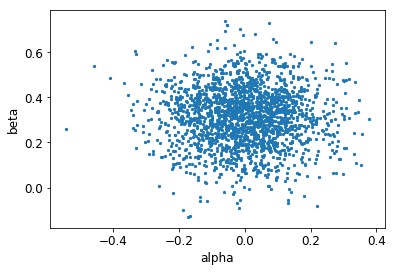

In [31]:
samples = fit.extract(permuted=True)
plt.figure()
# preview 2000 samples
plt.scatter(samples['alpha'][:2000], samples['beta'][:2000], 5)
plt.xlabel('alpha')
plt.ylabel('beta');

Compute the probability that the summer temperature is increasing.

In [32]:
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

Pr(beta > 0) = 0.9905


Plot the data, the model fit and prediction for year 2016.

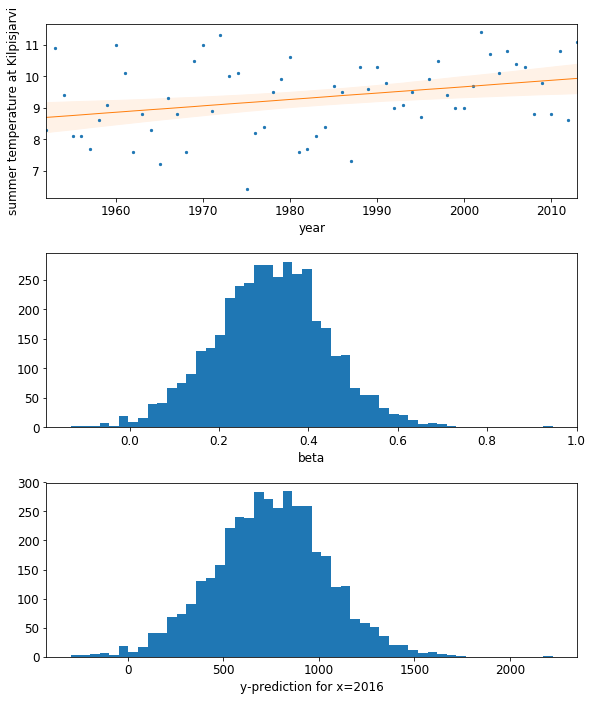

In [33]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 1.4  # width
figsize[1] *= 2.5  # height
fig, axes = plt.subplots(3, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
# lighten color_line
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
# plot
ax = axes[0]
ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('summer temperature at Kilpisjarvi')
ax.set_xlim((1952, 2013))

# plot 2: histogram
ax = axes[1]
ax.hist(samples['beta'], 50)
ax.set_xlabel('beta')

# plot 3: histogram
ax = axes[2]
ax.hist(samples['ypred'], 50)
ax.set_xlabel('y-prediction for x={}'.format(xpred))

# make figure compact
fig.tight_layout();

## Linear Student's t model.

The temperatures used in the above analyses are averages over three months, which makes it more likely that they are normally distributed, but there can be extreme events in the feather and we can check whether more robust Student's t observation model woul give different results.

In [34]:
%cat lin_t.stan

// Linear student-t model
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
  real<lower=1, upper=80> nu;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  nu ~ gamma(2, 0.1); // Juarez and Steel(2010)
  y ~ student_t(nu, mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = student_t_lpdf(y[i] | nu, mu[i], sigma);
}


In [35]:
model = stan_utility.compile_model('lin_t.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [36]:
print(fit)

Inference for Stan model: anon_model_985e43a8fe28088e3317d00edd324bab.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -33.75    0.44  16.04 -66.21 -44.51 -33.28  -23.1  -3.05   1319    1.0
beta          0.02  2.2e-4 8.1e-3 6.3e-3   0.02   0.02   0.03   0.04   1319    1.0
sigma         1.08  2.9e-3   0.11   0.88   1.01   1.08   1.16   1.32   1506    1.0
nu           24.32    0.32  13.38   5.94  14.13  21.71  31.66  56.93   1763    1.0
mu[0]         8.65  7.3e-3   0.29   8.07   8.46   8.66   8.85   9.23   1597    1.0
mu[1]         8.67  7.1e-3   0.29    8.1   8.49   8.68   8.86   9.24   1614    1.0
mu[2]          8.7  6.9e-3   0.28   8.13   8.52    8.7   8.88   9.25   1632    1.0
mu[3]         8.72  6.7e-3   0.27   8.17   8.54   8.72    8.9   9.25   1652    1.0
mu[4]         8.74  6.5e-3   0.27    8.2   8.57   8.75   8.92   

Without standardization we'are again get smaller `n_eff`'s, but large enough for practical purposes.

Check the treedepth, E-BFMI, and divergences

In [37]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

78 of 4000 iterations saturated the maximum tree depth of 10 (1.95%)
Run again with max_depth set to a larger value to avoid saturation
0.0 of 4000 iterations ended with a divergence (0.0%)


We see again many iterations saturating the maximum tree depth, which is harmful for the efficiency but doesn't invalidate the results.

Compute the probability that the summer temperature is increasing.

In [38]:
samples = fit.extract(permuted=True)
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

Pr(beta > 0) = 0.99725


We get similar probability as with Gaussian obervation model.

Plot the data, the model fit, and the marginal posteriors for sigma and nu.

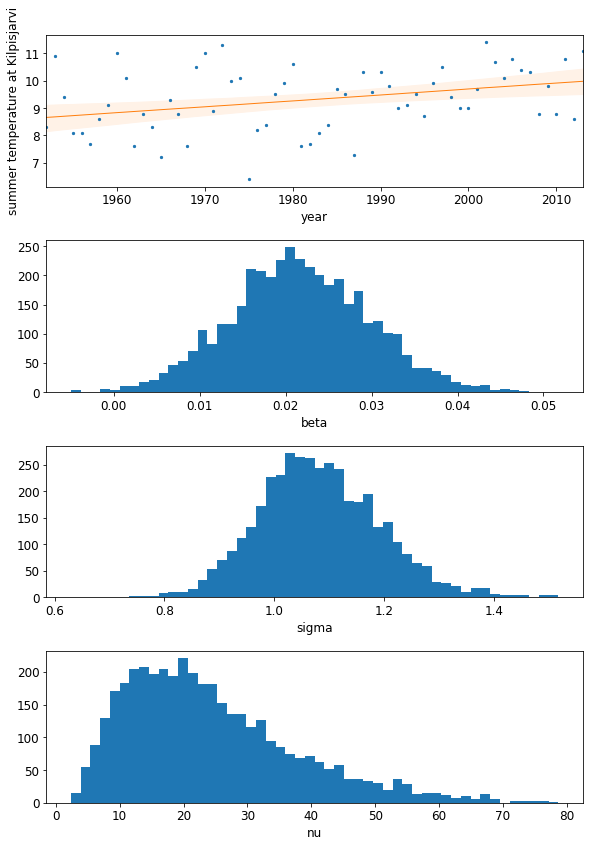

In [39]:
# make slightly wider figure of 4 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 1.4  # width
figsize[1] *= 3  # height
fig, axes = plt.subplots(4, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
# lighten color_line
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
# plot
ax = axes[0]
ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('summer temperature at Kilpisjarvi')
ax.set_xlim((1952, 2013))

# plot 2: histogram
ax = axes[1]
ax.hist(samples['beta'], 50)
ax.set_xlabel('beta')

# plot 3: histogram
ax = axes[2]
ax.hist(samples['sigma'], 50)
ax.set_xlabel('sigma')

# plot 4: histogram
ax = axes[3]
ax.hist(samples['nu'], 50)
ax.set_xlabel('nu')

# make figure compact
fig.tight_layout();

The posterior of nu reveals that Gaussian model is likely to be ok, as Student's t with `nu > 20` is very close to Gaussian.

# Comparison of k groups with hierarchical models

Let's compare the temperatures in three summer months.

In [40]:
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
# Is there difference between different summer months?
x = np.tile(np.arange(1, 4), d.shape[0]) # summer months are numbered from 1 to 3
y = d[:, 1:4].ravel()
N = len(x)
data = dict(
    N = N,
    K = 3,  # 3 groups
    x = x,  # group indicators
    y = y   # observations
)

## Common variance (ANOVA) model

In [41]:
%cat grp_aov.stan

// Comparison of k groups with common variance (ANOVA)
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu[x], sigma);
}


Fit the model

In [42]:
model = stan_utility.compile_model('grp_aov.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [43]:
print(fit)

Inference for Stan model: anon_model_7564a28d1f0313ff396284979a4361d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]   7.54  3.1e-3    0.2   7.17   7.41   7.54   7.68   7.92   4000    1.0
mu[1]  10.96  3.1e-3    0.2  10.58  10.82  10.96   11.1  11.36   4000    1.0
mu[2]   9.44  3.1e-3   0.19   9.05   9.31   9.44   9.57   9.83   4000    1.0
sigma   1.53  1.3e-3   0.08   1.38   1.47   1.52   1.58    1.7   4000    1.0
lp__  -170.9    0.03   1.38 -174.2 -171.6 -170.6 -169.9 -169.1   2294    1.0

Samples were drawn using NUTS at Wed Aug 23 10:33:03 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Check the treedepth, E-BFMI, and divergences

In [44]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


Plot group mean distributions and matrix of probabilities that one mu is larger than other.

Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


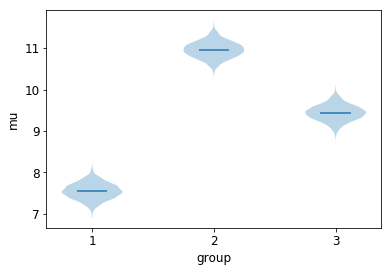

In [45]:
# matrix of probabilities that one mu is larger than other
mu = fit.extract(permuted=True)['mu']
ps = np.zeros((3, 3))
for k1 in range(3):
    for k2 in range(k1+1, 3):
        ps[k1, k2] = np.mean(mu[:, k1] > mu[:, k2])
        ps[k2, k1] = 1 - ps[k1, k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)

# plot violins
plt.violinplot(mu, showmeans=True, showextrema=False)
plt.xticks(np.arange(1, 4))
plt.xlabel('group')
plt.ylabel('mu');

## Common variance and hierarchical prior for mean.

Results do not differ much from the previous, because there is only
few groups and quite much data per group, but this works as an example of a hierarchical model.


In [46]:
%cat grp_prior_mean.stan

// Comparison of k groups with common variance and
// hierarchical prior for the mean
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
  mu0 ~ normal(10,10);      // weakly informative prior
  sigma0 ~ cauchy(0,4);     // weakly informative prior
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  sigma ~ cauchy(0,4);      // weakly informative prior
  y ~ normal(mu[x], sigma);
}


Fit the model

In [47]:
model = stan_utility.compile_model('grp_prior_mean.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)

Using cached StanModel


Plot group mean distributions and matrix of probabilities that one mu is larger than other.

Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


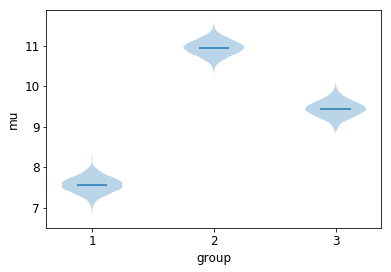

In [48]:
# matrix of probabilities that one mu is larger than other
mu = fit.extract(permuted=True)['mu']
ps = np.zeros((3, 3))
for k1 in range(3):
    for k2 in range(k1+1, 3):
        ps[k1, k2] = np.mean(mu[:, k1] > mu[:, k2])
        ps[k2, k1] = 1 - ps[k1, k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)

# plot violins
plt.violinplot(mu, showmeans=True, showextrema=False)
plt.xticks(np.arange(1, 4))
plt.xlabel('group')
plt.ylabel('mu');

## Unequal variance and hierarchical prior for mean and variance

Results do not differ much from the previous, because there is only
few groups and quite much data per group, but this works as an example of a hierarchical model.

In [49]:
%cat grp_prior_mean_var.stan

// Comparison of k groups with unequal variance and
// hierarchical priors for the mean and the variance
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  real mu0;                 // prior mean
  real<lower=0> musigma0;   // prior std
  vector[K] mu;             // group means
  real lsigma0;             // prior mean
  real<lower=0> lsigma0s;   // prior std
  vector<lower=0>[K] sigma; // group stds
}
model {
  mu0 ~ normal(10, 10);       // weakly informative prior
  musigma0 ~ cauchy(0,10);    // weakly informative prior
  mu ~ normal(mu0, musigma0); // population prior with unknown parameters
  lsigma0 ~ normal(0,1);      // weakly informative prior
  lsigma0s ~ normal(0,1);     // weakly informative prior
  sigma ~ cauchy(lsigma0, lsigma0s); // population prior with unknown parameters
  y ~ normal(mu[x], sigma[x]);
}


Fit the model

In [50]:
model = stan_utility.compile_model('grp_prior_mean_var.stan')
fit = model.sampling(data=data)
samples = fit.extract(permuted=True)

Using cached StanModel


Plot group mean distributions and matrix of probabilities that one mu is larger than other:

std(mu0): 2.21
Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


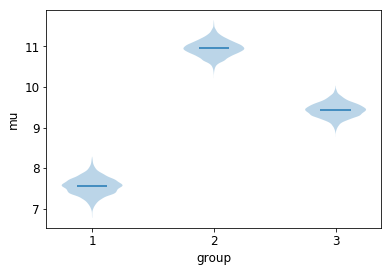

In [51]:
samples = fit.extract(permuted=True)
print("std(mu0): {:.2f}".format(np.std(samples['mu0'])))
mu = samples['mu']

# matrix of probabilities that one mu is larger than other
ps = np.zeros((3, 3))
for k1 in range(3):
    for k2 in range(k1+1, 3):
        ps[k1, k2] = np.mean(mu[:, k1] > mu[:, k2])
        ps[k2, k1] = 1 - ps[k1, k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)

# plot violins
plt.violinplot(mu, showmeans=True, showextrema=False)
plt.xticks(np.arange(1, 4))
plt.xlabel('group')
plt.ylabel('mu');